Kenan Stredic and Aaryan Singh

In [ ]:
# Cell 1: Imports and Data Preprocessing
import numpy as np
import pandas as pd
import tensorflow
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
from hyperopt import fmin, tpe, hp
import gdown

# Specify the Google Drive folder URL where the CIFAR-10 dataset is shared

google_drive_folder_url = 'https://drive.google.com/drive/folders/13YmfTz_jTwN1QtHxVDqd1o7lyb7ptoae?usp=sharing'

train_labels_url = 'https://drive.google.com/uc?id=1xiWQWbv2DMVV_Q_PrPhIm4HRwt7mOjqI'

# Download the CIFAR-10 train labels file from the Google Drive folder
gdown.download(train_labels_url, 'trainLabels.csv', quiet=False)

# Load CIFAR-10 dataset using the downloaded train labels file
def load_cifar10_dataset(train_labels_file):
    train_labels = pd.read_csv(train_labels_url)

    # Load training data
    x_train = []
    y_train = []
    label_to_index = {label: index for index, label in enumerate(train_labels['label'].unique())}
    for row in train_labels.iterrows():
        image_id, label = row[1]['id'], row[1]['label']
        image_path = f'{train_labels_file}/train/train/{image_id}.png'
        image_data = plt.imread(image_path)
        x_train.append(image_data)
        y_train.append(label_to_index[label])

    x_train = np.array(x_train)
    y_train = np.array(y_train)

    return x_train, y_train

# Load CIFAR-10 data
cifar_10_dir = '/content/drive/MyDrive/CS 4372 HW3'
x_train, y_train = load_cifar10_dataset(cifar_10_dir)


# Data preprocessing
x_train = x_train.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1).astype("uint8")
x_train = np.array([cv2.resize(x, (64, 64)) for x in x_train])
y_train = to_categorical(y_train, num_classes=10)

# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)


Downloading...
From: https://drive.google.com/uc?id=1xiWQWbv2DMVV_Q_PrPhIm4HRwt7mOjqI
To: /content/trainLabels.csv
100%|██████████| 589k/589k [00:00<00:00, 92.3MB/s]


FileNotFoundError: ignored

In [ ]:
# Cell 2: Define the Model
def create_model(params):
    input_shape = (64, 64, 3)  # Adjust the input shape to match the resized image dimensions

    # Use EfficientNetB0 model instead of MobileNetV2
    base_model = EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet')
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(params['num_units'], activation=params['activation'])(x)
    x = Dropout(params['dropout'])(x)
    predictions = Dense(10, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze pre-trained layers
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=params['learning_rate']), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Cell 3: Define the hyperparameter search space
space = {
    'num_units': hp.choice('num_units', [128, 256, 512]),
    'activation': hp.choice('activation', ['relu', 'tanh']),
    'dropout': hp.uniform('dropout', 0.2, 0.5),
    'learning_rate': hp.loguniform('learning_rate', -4, -2),
    'batch_size': hp.choice('batch_size', [32, 64]),
    'epochs': 10
}

# Initialize a list to store parameter testing and tuning details
parameter_log = []

# Modify the objective function to log hyperparameters and accuracy
def objective(params):
    model = create_model(params)
    history = model.fit(x_train, y_train, batch_size=params['batch_size'], epochs=params['epochs'], validation_data=(x_val, y_val), verbose=0)
    val_loss = history.history['val_loss'][-1]
    train_acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]

    # Log the hyperparameters and accuracy
    parameter_log.append({
        'Number of units': params['num_units'],
        'Activation Function': params['activation'],
        'Dropout Rate': params['dropout'],
        'Learning Rate': params['learning_rate'],
        'Batch Size': params['batch_size'],
        'Train Accuracy': train_acc,
        'Validation Accuracy': val_acc
    })

    return val_loss

# Perform hyperparameter optimization
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10)


16705208/16705208 [==============================] - 0s 0us/step

100%|██████████| 10/10 [31:58<00:00, 191.82s/trial, best loss: 2.3034892082214355]


In [ ]:
# Cell 4: Get the best parameters
best_params = {
    'num_units': [128, 256, 512][best['num_units']],
    'activation': ['relu', 'tanh'][best['activation']],
    'dropout': best['dropout'],
    'learning_rate': best['learning_rate'],
    'batch_size': [32, 64][best['batch_size']],
    'epochs': 10
}

# Create and train the best model
best_model = create_model(best_params)
history = best_model.fit(x_train, y_train, batch_size=best_params['batch_size'], epochs=best_params['epochs'], validation_data=(x_val, y_val), verbose=1)

# Evaluate the best model on the test set
test_loss, test_accuracy = best_model.evaluate(x_val, y_val, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Epoch 1/10
625/625 [==============================] - 23s 25ms/step - loss: 2.4104 - accuracy: 0.0996 - val_loss: 2.3052 - val_accuracy: 0.1040
Epoch 2/10
625/625 [==============================] - 14s 23ms/step - loss: 2.3079 - accuracy: 0.0971 - val_loss: 2.3042 - val_accuracy: 0.0979
Epoch 3/10
625/625 [==============================] - 12s 19ms/step - loss: 2.3056 - accuracy: 0.0992 - val_loss: 2.3061 - val_accuracy: 0.0973
Epoch 4/10
625/625 [==============================] - 11s 18ms/step - loss: 2.3047 - accuracy: 0.1001 - val_loss: 2.3060 - val_accuracy: 0.1023
Epoch 5/10
625/625 [==============================] - 12s 20ms/step - loss: 2.3045 - accuracy: 0.1009 - val_loss: 2.3039 - val_accuracy: 0.0979
Epoch 6/10
625/625 [==============================] - 12s 20ms/step - loss: 2.3080 - accuracy: 0.1004 - val_loss: 2.3060 - val_accuracy: 0.0933
Epoch 7/10
625/625 [==============================] - 12s 20ms/step - loss: 2.3044 - accuracy: 0.1000 - val_loss: 2.3045 - val_accuracy:

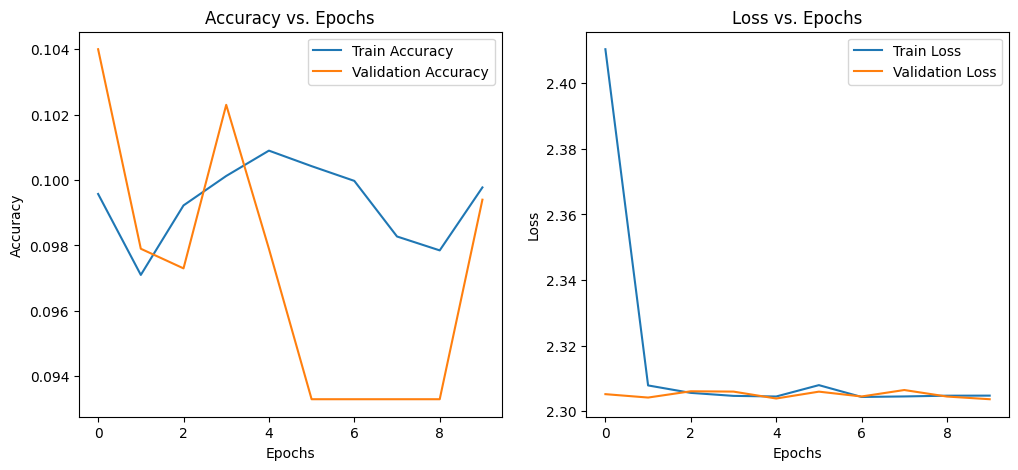

In [ ]:
# Cell 5: Plot Training History
# Plot Training History
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Cell 6: Display the Parameter Testing and Tuning Table
# Display the parameter testing and tuning table
print("\nParameter Testing and Tuning Table:")
for i, params in enumerate(parameter_log):
    print(f"Iteration {i + 1}:")
    for key, value in params.items():
        print(f"{key} = {value}")


Parameter Testing and Tuning Table:
Iteration 1:
Number of units = 256
Activation Function = relu
Dropout Rate = 0.23475500698776788
Learning Rate = 0.02112349787265434
Batch Size = 64
Train Accuracy = 0.09825000166893005
Validation Accuracy = 0.1014999970793724
Iteration 2:
Number of units = 128
Activation Function = relu
Dropout Rate = 0.26359659009791303
Learning Rate = 0.05045215820444954
Batch Size = 32
Train Accuracy = 0.09867499768733978
Validation Accuracy = 0.09790000319480896
Iteration 3:
Number of units = 512
Activation Function = relu
Dropout Rate = 0.2741944108978339
Learning Rate = 0.07760989813802911
Batch Size = 32
Train Accuracy = 0.09929999709129333
Validation Accuracy = 0.1023000031709671
Iteration 4:
Number of units = 512
Activation Function = relu
Dropout Rate = 0.20027099663996864
Learning Rate = 0.03052845748891734
Batch Size = 32
Train Accuracy = 0.09937500208616257
Validation Accuracy = 0.10400000214576721
Iteration 5:
Number of units = 128
Activation Function